In [1]:
from sklearn.decomposition import PCA
from model.TransE import *
from model.ConvKB import ConvKB
from model.utils import *
from model.CustomTripletMarginLoss import CustomTripletMarginLoss
from argparse import Namespace
import torch
import torch.nn as nn
import sys
from torch.autograd import Variable
import torch.optim as optim
from numpy import linalg as LA
import numpy as np
from math import log10,floor
import json
import pickle
from sklearn.cluster import KMeans

In [2]:
if torch.cuda.is_available():
    net = torch.load("./data/GENE/ConvKB.pkl")
else:
    net = torch.load("./data/GENE/ConvKB.pkl", map_location=lambda storage, loc: storage)
net = list(net.items())
# 1: entity
# 2: relation
data_train = net[0][1].cpu().numpy()

In [3]:
with open("./data/GENE/db.json", "rb") as f:
    data = json.load(f)
    f.close()
with open("./data/GENE/id_dict", "rb") as f:
    id_dict = pickle.load(f)
    f.close()
processed_entity_2_id = load_data("./data/GENE/entity2id.txt", ignore_first=True)
relation_2_id = load_data("./data/GENE/relation2id.txt", ignore_first=True)
processed_id_2_entity = dict()
i = 0
with open("./data/GENE/entity2id.txt", 'r') as f:
    for line in f:
        if True and i == 0:
            i += 1
            continue
        line = line.strip()
        if line == '':
            continue
        parts = line.split("\t")
        processed_id_2_entity[int(parts[1])] = parts[0]

In [4]:
len(data_train)

26986

In [5]:
len(processed_entity_2_id)

26986

In [6]:
get_index_gene = []
for gene,index in processed_entity_2_id.items():
    if gene in id_dict.keys():
        get_index_gene.append(index)

In [34]:
X = data_train[get_index_gene]
#Y = np.random.randint(5, size=(20047))

In [61]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [62]:
Y = kmeans.labels_

In [63]:
print(X.shape,Y.shape)

(20047, 100) (20047,)


In [64]:
import pandas as pd

feat_cols = ['number'+str(i) for i in range(X.shape[1]) ]

df = pd.DataFrame(X,columns=feat_cols)
df['label'] = Y
df['label'] = df['label'].apply(lambda i: str(i))

# X, y = None, None

print ('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (20047, 101)


In [65]:
rndperm = np.random.permutation(df.shape[0])

In [66]:
pca = PCA(n_components=5)
pca_result = pca.fit_transform(df[feat_cols].values)

df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]

print ('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.31616157 0.08848054 0.04910343 0.04488358 0.03987655]


In [67]:
from ggplot import *

chart = ggplot(df.loc[rndperm[:3000],:], aes(x='pca-one', y='pca-two', color='label') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")

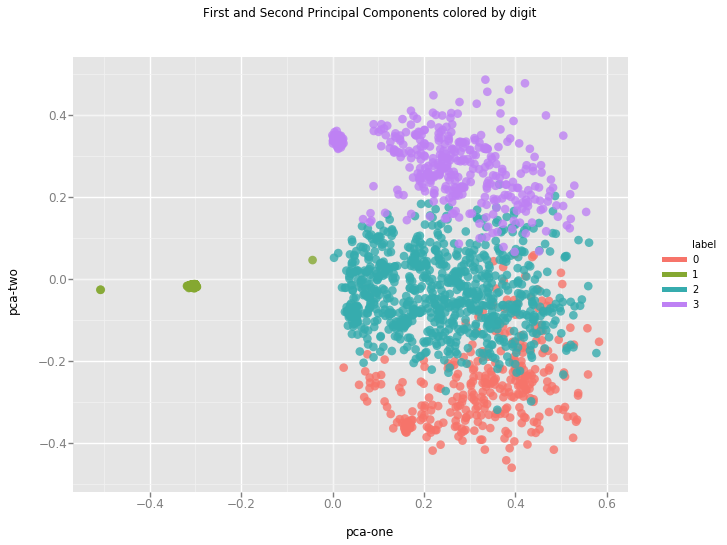

<ggplot: (7023719919)>

In [68]:
chart

In [69]:
import time

from sklearn.manifold import TSNE

n_sne = 7000

time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.020s...
[t-SNE] Computed neighbors for 7000 samples in 6.436s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.001651
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.342888
[t-SNE] KL divergence after 300 iterations: 2.258828
t-SNE done! Time elapsed: 52.079668045043945 seconds


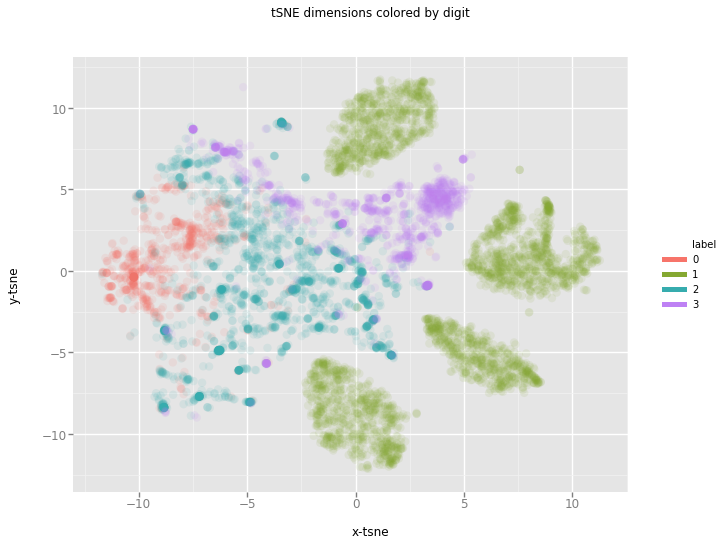

<ggplot: (7024104624)>

In [70]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne', y='y-tsne', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by digit")
chart

In [28]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(df[feat_cols].values)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.9378988742828369


In [29]:
n_sne = 20047

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50[rndperm[:n_sne]])

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 20047 samples in 0.056s...
[t-SNE] Computed neighbors for 20047 samples in 22.429s...
[t-SNE] Computed conditional probabilities for sample 1000 / 20047
[t-SNE] Computed conditional probabilities for sample 2000 / 20047
[t-SNE] Computed conditional probabilities for sample 3000 / 20047
[t-SNE] Computed conditional probabilities for sample 4000 / 20047
[t-SNE] Computed conditional probabilities for sample 5000 / 20047
[t-SNE] Computed conditional probabilities for sample 6000 / 20047
[t-SNE] Computed conditional probabilities for sample 7000 / 20047
[t-SNE] Computed conditional probabilities for sample 8000 / 20047
[t-SNE] Computed conditional probabilities for sample 9000 / 20047
[t-SNE] Computed conditional probabilities for sample 10000 / 20047
[t-SNE] Computed conditional probabilities for sample 11000 / 20047
[t-SNE] Computed conditional probabilities for sample 12000 / 20047
[t-SNE] Computed conditional probabilities for s

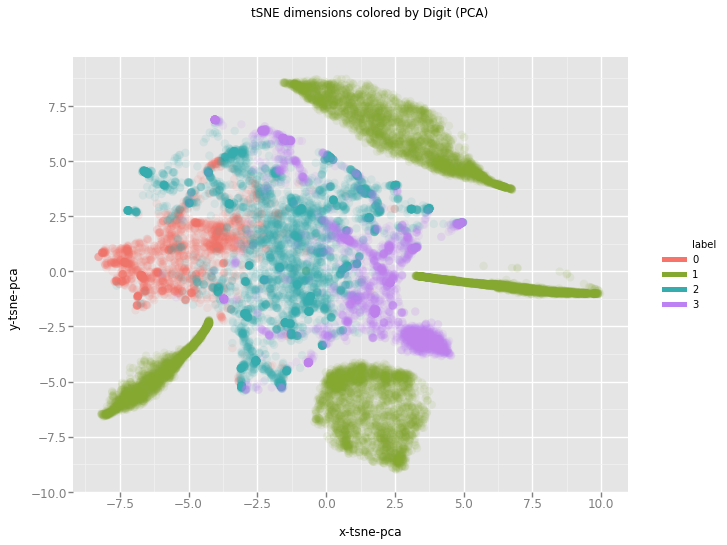

<ggplot: (-9223372029830865443)>

In [30]:
df_tsne = None
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne-pca'] = tsne_pca_results[:,0]
df_tsne['y-tsne-pca'] = tsne_pca_results[:,1]

chart = ggplot( df_tsne, aes(x='x-tsne-pca', y='y-tsne-pca', color='label') ) \
        + geom_point(size=70,alpha=0.1) \
        + ggtitle("tSNE dimensions colored by Digit (PCA)")
chart